In [2]:
import pandas as pd

pd.set_option('display.max_columns', None)

df = pd.read_csv('../csv/clean_data2.csv')
df.head()

,BOROUGH,ZIP CODE,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,Latitude,Longitude,Match,Year,Month,Day,Weekday,Building Age,Price per Square Feet,Distance
0,2,10457.0,3167.0,1899.0,980000.0,40.841270,-73.901313,0,2022,9,8,3,125.0,309,10.257899
1,2,10457.0,2048.0,1901.0,655000.0,40.850353,-73.898824,0,2022,11,1,1,123.0,319,11.004018
2,2,10457.0,1587.0,1899.0,520000.0,40.853630,-73.895963,0,2022,10,26,2,125.0,327,11.205630
3,2,10457.0,2820.0,1952.0,720000.0,40.851764,-73.896429,0,2022,2,23,2,72.0,255,11.041775
4,2,10458.0,1260.0,1910.0,499999.0,40.855949,-73.892532,0,2022,4,28,3,114.0,396,11.303655


## XGBoost

In [3]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

features = ['BOROUGH', 'ZIP CODE', 'GROSS SQUARE FEET', 'SALE PRICE', 'Latitude', 'Longitude', 'Month', 'Day', 'Weekday', 'Building Age', 'Price per Square Feet', 'Distance']
target = 'Match'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42)

steps = [('Rescale', StandardScaler()),
         ('xgb', XGBClassifier(random_state=42))]
xgb_model = Pipeline(steps)

param_grid = {'xgb__gamma': [0.0, 0.1, 0.2, 0.3], 
              'xgb__learning_rate': [0.05, 0.1], 
              'xgb__n_estimators': [100, 300, 500], 
              'xgb__max_depth': [3, 5, 10], 
              'xgb__lambda': [0.5, 1, 5], 
              'xgb__min_child_weight': [3, 5, 7]}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='precision')
grid_search.fit(X_train, y_train)

best_xgb_params = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_

print(best_xgb_params)

# Predict on the training set
y_train_pred = best_xgb_model.predict(X_train)

# Predict on the testing set
y_test_pred = best_xgb_model.predict(X_test)

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

{'xgb__gamma': 0.1, 'xgb__lambda': 0.5, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 10, 'xgb__min_child_weight': 3, 'xgb__n_estimators': 300}
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     56329
           1       0.93      0.77      0.84     16557

    accuracy                           0.94     72886
   macro avg       0.93      0.88      0.90     72886
weighted avg       0.93      0.94      0.93     72886

              precision    recall  f1-score   support

           0       0.91      0.97      0.94     14194
           1       0.85      0.66      0.74      4028

    accuracy                           0.90     18222
   macro avg       0.88      0.81      0.84     18222
weighted avg       0.90      0.90      0.89     18222



In [4]:
from sklearn.metrics import roc_auc_score

y_train_proba = best_xgb_model.predict_proba(X_train)
y_test_proba = best_xgb_model.predict_proba(X_test)

print(roc_auc_score(y_train, y_train_proba[:, 1]))
print(roc_auc_score(y_test, y_test_proba[:, 1]))

0.9767986405993573
0.9209004192716645


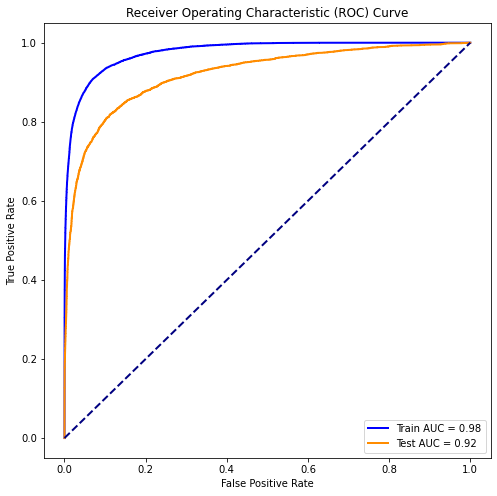

In [5]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Assuming you have calculated y_train_proba for the training set

# Calculate the ROC curve and AUC for training set
fpr_train, tpr_train, thresholds_train = metrics.roc_curve(y_train, y_train_proba[:, 1], pos_label=1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

# Plot the ROC curve for training set
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f'Train AUC = {roc_auc_train:.2f}')

# Assuming you have calculated y_test_proba for the testing set

# Calculate the ROC curve and AUC for testing set
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test, y_test_proba[:, 1], pos_label=1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

# Plot the ROC curve for testing set
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test AUC = {roc_auc_test:.2f}')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()

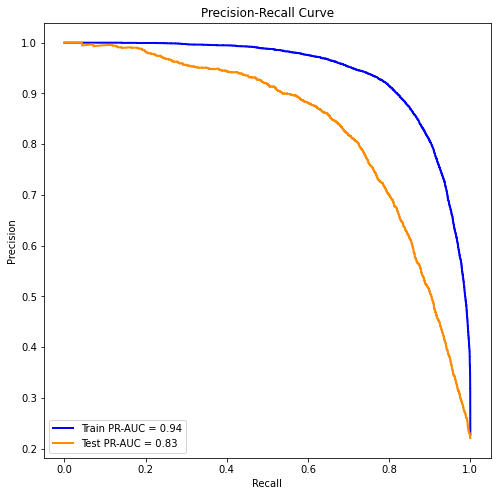

In [6]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Assuming you have calculated y_train_proba for the training set

# Calculate precision-recall curve and AUC for training set
precision_train, recall_train, _ = metrics.precision_recall_curve(y_train, y_train_proba[:, 1], pos_label=1)
pr_auc_train = metrics.auc(recall_train, precision_train)

# Plot the precision-recall curve for training set
plt.figure(figsize=(8, 8))
plt.plot(recall_train, precision_train, color='blue', lw=2, label=f'Train PR-AUC = {pr_auc_train:.2f}')

# Assuming you have calculated y_test_proba for the testing set

# Calculate precision-recall curve and AUC for testing set
precision_test, recall_test, _ = metrics.precision_recall_curve(y_test, y_test_proba[:, 1], pos_label=1)
pr_auc_test = metrics.auc(recall_test, precision_test)

# Plot the precision-recall curve for testing set
plt.plot(recall_test, precision_test, color='darkorange', lw=2, label=f'Test PR-AUC = {pr_auc_test:.2f}')

# Set labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

# Show the plot
plt.show()

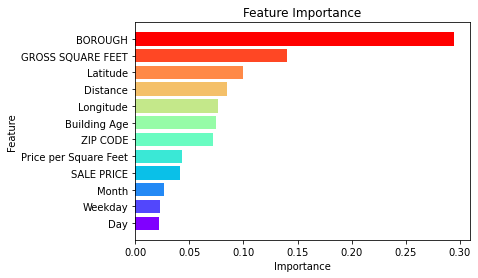

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have 'importances' and 'feature_names' defined
importances = best_xgb_model.steps[1][1].feature_importances_
feature_names = X_train.columns

# Sort feature importances and corresponding feature names
sorted_indices = np.argsort(importances)  # Leave the order as is (lowest to highest)
sorted_importances = importances[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]

# Set a colorful colormap ('rainbow')
colors = plt.cm.rainbow(np.linspace(0, 1, len(importances)))

# Create a horizontal bar plot with colorful bars
plt.barh(range(len(importances)), sorted_importances, color=colors, align="center")
plt.yticks(range(len(importances)), sorted_feature_names)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

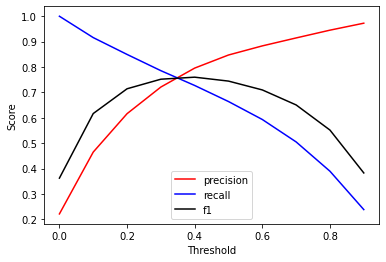

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score

# thresholds = np.linspace(0, 1, 10)
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
precisions = []
recalls = []
f1s = []

for threshold in thresholds:
    y_test_predic = (y_test_proba[:, 1] > threshold).astype(int)
    
    # Calculate precision, recall, and f1 for class 'Match' being 1 without averaging
    precisions.append(precision_score(y_test, y_test_predic, labels=[1], average=None)[0])
    recalls.append(recall_score(y_test, y_test_predic, labels=[1], average=None)[0])
    f1s.append(f1_score(y_test, y_test_predic, labels=[1], average=None)[0])

plt.plot(thresholds, precisions, color="red", label="precision")
plt.plot(thresholds, recalls, color="blue", label="recall")
plt.plot(thresholds, f1s, color="black", label="f1")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

In [9]:
import numpy as np

# Find the index where recall is closest to 0.4
recall_target = 0.4
index_closest_recall = np.argmin(np.abs(np.array(recalls) - recall_target))

# Get the corresponding precision, recall, and f1 at that index
precision_at_target_recall = precisions[index_closest_recall]
recall_at_target_recall = recalls[index_closest_recall]
f1_at_target_recall = f1s[index_closest_recall]
threshold_at_target_recall = thresholds[index_closest_recall]

print(f'Precision at Recall = {recall_target:.2f}: {precision_at_target_recall:.2f}')
print(f'Recall at Recall = {recall_target:.2f}: {recall_at_target_recall:.2f}')
print(f'F1 Score at Recall = {recall_target:.2f}: {f1_at_target_recall:.2f}')
print(f'Threshold at Recall = {recall_target:.2f}: {threshold_at_target_recall:.2f}')

Precision at Recall = 0.40: 0.95
Recall at Recall = 0.40: 0.39
F1 Score at Recall = 0.40: 0.55
Threshold at Recall = 0.40: 0.80


In [10]:
y_train_predic = (y_train_proba[:, 1] > 0.80).astype(int)
    
# Calculate precision, recall, and f1 for class 'Match' being 1 without averaging
precision_train = precision_score(y_train, y_train_predic, labels=[1], average=None)[0]
recall_train = recall_score(y_train, y_train_predic, labels=[1], average=None)[0]
f1_train = f1_score(y_train, y_train_predic, labels=[1], average=None)[0]
# Print the results
print(f'Training Precision at Threshold = 0.80: {precision_train:.2f}')
print(f'Training Recall at Threshold = 0.80: {recall_train:.2f}')
print(f'Training F1 Score at Threshold = 0.80: {f1_train:.2f}')

Training Precision at Threshold = 0.80: 0.99
Training Recall at Threshold = 0.80: 0.46
Training F1 Score at Threshold = 0.80: 0.62
